In [2]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
torch.cuda.get_device_name(0)


cuda:0


'NVIDIA GeForce RTX 4070 Laptop GPU'

In [1]:
data = [[] for i in range(10)]

In [4]:
## Cloud_Server.py
## Distributed -> C_server -> L_server -> Edge
from Model import mnistCNN
import torch
import random
import numpy as np
from torch import optim
from torch.autograd import Variable
from Data_Loader import loader

class CS(object):
    def __init__(self, size, data_loader):
        self.size = size
        self.test_loader = data_loader[1]
        self.model = mnistCNN().to(device)
        self.optimizer = optim.SGD(self.model.parameters(), lr=1e-2)
        self.accuracy = []
        self.ESs = [None]*size
        self.count=0

    def __average_weights(self,ESs):
        for info in ESs[1:]:
            for key in info:
                ESs[0][key] = info[key] + ESs[0][key]
        for key in ESs[0]:
            ESs[0][key] = ESs[0][key] / self.size  
        weights = ESs[0]
        return weights

    def __test(self):
        test_correct = 0
        self.model.eval()
        with torch.no_grad():
            for data, target in self.test_loader:
                data, target = Variable(data).to(device),Variable(target).to(device)
                output = self.model(data)
                pred = output.argmax(dim=1, keepdim=True)
                test_correct += pred.eq(target.view_as(pred)).sum().item()
        return test_correct / len(self.test_loader.dataset)

    def aggregate(self):
        weights_info = self.ESs
        weights = self.__average_weights(weights_info)
        self.model.load_state_dict(weights)
        test_accuracy = self.__test()
        self.accuracy.append(test_accuracy)
        print('\n[Global Model]  Test Accuracy: {:.2f}%\n'.format(test_accuracy * 100.))

In [5]:
## Edge_Server.py
import torch
from torch import optim
from torch.autograd import Variable

class ES():
    def __init__(self, size, data_loader, CS):
        self.size = size
        self.test_loader = data_loader[1]
        self.accuracy = []
        self.clients = [None]*size
        self.count=0
        self.CS = CS
        #self.model = self.CS.model
        self.model =  mnistCNN().to(device)
        self.model.load_state_dict(self.CS.model.state_dict()) 


    
    def load_global_model(self):
        self.model.load_state_dict(self.CS.model.state_dict()) 
        
    
    def __average_weights(self,clients):
        for info in clients[1:]:
            for key in info:
                clients[0][key]=info[key] + clients[0][key]
        for key in clients[0]:
            clients[0][key]=clients[0][key]/self.size  
        weights=clients[0]
        return weights


## Optional 
    def __test(self):
        test_correct = 0
        self.model.eval()
        with torch.no_grad():
            for data, target in self.test_loader:
                data, target = Variable(data).to(device), Variable(target).to(device)
                output = self.model(data)
                pred = output.argmax(dim=1, keepdim=True)
                test_correct += pred.eq(target.view_as(pred)).sum().item()
        return test_correct / len(self.test_loader.dataset)

    def aggregate(self):
        weights_info = self.clients
        weights = self.__average_weights(weights_info)
        self.model.load_state_dict(weights)
        self.CS.ESs[self.CS.count%self.CS.size]=weights
        self.CS.count+=1
        #test_accuracy = self.__test()
        #self.accuracy.append(test_accuracy)
        #print('\n[Global Model]  Test Accuracy: {:.2f}%\n'.format(test_accuracy * 100.))

In [6]:
## Hier_Client.py
import torch

from torch import nn
from torch.autograd import Variable
class Client(object):
    def __init__(self, rank, data_loader, local_epoch, ES, select = False):
        # seed
        self.accuracy = []
        self.rank = rank
        self.local_epoch = local_epoch
        self.ES=ES
        self.test_loader = data_loader[1]
        self.train_loader = iter(data_loader[0])
        self.select = select
        self.idx = 0

    @staticmethod
    def __load_global_model(self):
        model = mnistCNN().to(device)
        model.load_state_dict(self.ES.model.state_dict()) 
        return model
    
    def __test(self, model):
        test_correct = 0
        model.eval()
        with torch.no_grad():
            for data, target in self.test_loader:
                data, target = Variable(data).to(device),Variable(target).to(device)
                output = model(data)
                pred = output.argmax(dim=1, keepdim=True)
                test_correct += pred.eq(target.view_as(pred)).sum().item()
        return test_correct / len(self.test_loader.dataset)

    def __train(self, model):
        # update local model 
        train_loss = 0
        train_correct = 0
        model.train()
        optimizer = optim.SGD(model.parameters(), lr=1e-2)
        scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                        lr_lambda=lambda epoch: 0.95 ** epoch,
                                        last_epoch=-1,
                                        verbose=False) 
        chk=0
        for data, target in self.train_loader:
            chk+=1
            data, target = Variable(data).to(device), Variable(target).to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = nn.CrossEntropyLoss()(output, target)
            loss.backward()
            optimizer.step()     
            """
            if(e==self.local_epoch-1):
                train_loss += loss ## 필요시 local_epoch 마다 찍어보기. 현 상태 -> 각 client의 마지막 local epoch 데이터 저장
                pred = output.argmax(dim=1, keepdim=True)
                train_correct += pred.eq(target.view_as(pred)).sum().item()
            """
            if(chk ==1):
                break
        scheduler.step()
            
        #print('[Rank {:>2}]  Loss: {:>4.6f},  Accuracy: {:>.4f}'.format(
         #   self.rank,
          #  train_loss,
            ##train_correct / len(self.train_loader.dataset)
           # train_correct / 64
        #))
        weights=model.state_dict()
        return weights
    

    def run(self):
        model = self.__load_global_model(self)
        for e in range(self.local_epoch):
            weights = self.__train(model=model)
        
            if(self.select):
                    self.idx+=1
                    test_accuracy = self.__test(model=model)
                    data[self.rank].append(test_accuracy)
   
                    
        self.ES.clients[self.ES.count%self.ES.size]=weights
        self.ES.count+=1
        



In [7]:
import random
def fed_HIER(n_client, n_ES, CS_epoch, ES_epoch, CL_epoch, batch_size, type = "NON_IID"):
    print('Initialize Dataset...')
    # data_loader = loader('mnist', batch_size=batch_size)
    data_loader = loader('mnist', batch_size=batch_size, type = type)

    print('Initialize Cloud Server...')
    CS1 = CS(size=n_ES, data_loader=data_loader.get_loader([]))
    
    print('Initialize Edge Servers and Clients...')
    ESs = []
    clients = [[ None for i in range(n_client)] for j in range(n_ES) ]
    sel = True
    for i in range(n_ES):
        ESs.append(ES(size=n_client, data_loader=data_loader.get_loader([]), CS=CS1))
        for j in range(n_client):
            #if(i == 0 and j == 0):
            #    sel = True
            #else:
            #    sel = False
            clients[i][j]=Client(rank=j, data_loader=data_loader.get_loader(
            random.sample(range(0, 10), 4)
            ),local_epoch=CL_epoch,
            ES = ESs[i], select = sel )
 
    # federated learning
    for CSe in range(CS_epoch):
        print('\n================== Cloud Server Epoch {:>3} =================='.format(CSe + 1))
        for ESe in range(ES_epoch):
            #print('\n================== Edge Server Epoch {:>3} =================='.format(ESe + 1))
            for ESn in range(n_ES):
                #print("================= Edge Server :",ESn,"process =================")
                for c in clients[ESn]:
                    c.run()
                    
                ESs[ESn].aggregate()
        CS1.aggregate()
        
        for ESn in range(n_ES):
            ESs[ESn].load_global_model()
      
        



In [8]:
from matplotlib import pyplot as plt
def plot(server):
    n = len(server)
    accuracy = [server[i].accuracy for i in range(n)] 
    plt.xlabel("Training Epoch")
    plt.ylabel("Test Accuracy")

    plt.ylim(0, 1)
    plt.xlim(1, len(accuracy))
    plt.legend(loc=4)
    
    for i in range(n):
        plt.plot([e for e in range(1, len(accuracy[i]) + 1)], accuracy[i])


    plt.show()
                 


In [10]:
import copy
import pickle
if __name__ == '__main__':
    seed = 0
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if(device == 'cuda:0'):
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
    sample = [0 for i in range(5)]
    k_1 = [60, 15, 6, 60, 60]
    k_2 = [1, 4, 10, 4, 10]
    CS_epoch = [9, 9, 9, 2, 1]
    save = [[]for i in range(5)]
    for i in range(5):
        sample[i] = fed_HIER(n_client = 10, 
                      n_ES = 5, 
                      CS_epoch = (600//(k_1[i]*k_2[i])), 
                      ES_epoch =k_2[i], 
                      CL_epoch = k_1[i], 
                      batch_size =20)
        with open('data_'+str(i),'wb') as f:
            pickle.dump(data,f)
        data = [[] for i in range(10)]
        


Initialize Dataset...
Files already downloaded and verified
Files already downloaded and verified
Initialize Cloud Server...
Initialize Edge Servers and Clients...

================== Cloud Server Epoch   1 ==================

[Global Model]  Test Accuracy: 13.81%


================== Cloud Server Epoch   2 ==================

[Global Model]  Test Accuracy: 39.12%


================== Cloud Server Epoch   3 ==================

[Global Model]  Test Accuracy: 65.34%


================== Cloud Server Epoch   4 ==================

[Global Model]  Test Accuracy: 75.83%


================== Cloud Server Epoch   5 ==================

[Global Model]  Test Accuracy: 80.85%


================== Cloud Server Epoch   6 ==================

[Global Model]  Test Accuracy: 83.56%


================== Cloud Server Epoch   7 ==================

[Global Model]  Test Accuracy: 86.05%


================== Cloud Server Epoch   8 ==================

[Global Model]  Test Accuracy: 87.15%


================== 

0.678
0.7448
0.816
0.5911
0.5568


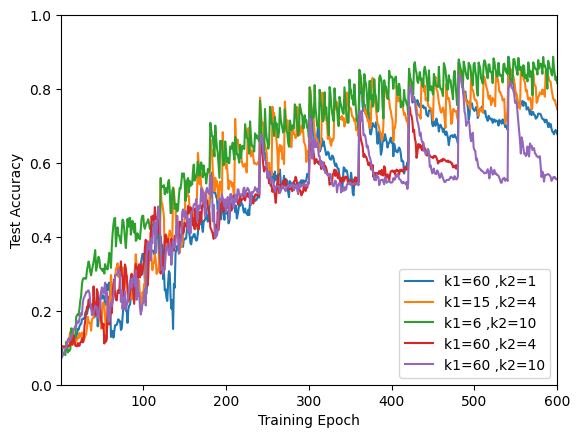

In [11]:

for i in range(5):
    with open('log_'+str(i)+'.txt','w',encoding='UTF-8') as f:
        for c in save[i] :
            f.write(str(c))
            f.write('\n')

plt.xlabel("Training Epoch")
plt.ylabel("Test Accuracy")

plt.ylim(0, 1)
plt.xlim(1, 600)

for i in range(5):
    print(save[i][len(save[i])-1])
    plt.plot([e for e in range(1, len(save[i]) + 1)], save[i], label='k1='+str(k_1[i])+' ,k2='+str(k_2[i]))

plt.legend(loc='best')
plt.show()